#### Download and deduplication

In [3]:
from ddgs import DDGS
import os
import requests

def collect_url_and_download_images(specie: str, max_pages: int=50, out_folder: str='dataset'):
    outdir = f"{out_folder}/{specie}/raw"
    os.makedirs(outdir, exist_ok=True)
    
    results = []
    for query in [specie, f"dinosaur {specie}"]:
        for i in range(max_pages):
            results.extend(DDGS().images(
                query=query,
                region="us-en",
                safesearch="off",
                max_results=1000,
                page=i))
            
    unique = {result["image"] for result in results}
    for idx, url in enumerate(unique, start=1):
        try:
            r = requests.get(url, timeout=20, headers={"User-Agent": "Mozilla/5.0"})
            r.raise_for_status()
            ext = os.path.splitext(url.split("?")[0])[1] or ".jpg"
            filename = os.path.join(outdir, f"{idx:04d}{ext}")
            with open(filename, "wb") as f:
                f.write(r.content)
            print(f"Downloaded {filename}")
        except Exception as e:
            print(f"Failed {url} -> {e}")\
                
    return outdir
            
import imagehash
from PIL import Image
import glob
import os

def remove_duplicate_images(folder_path: str, similarity_threshold: int = 4):
    """
    Remove duplicate/similar images using perceptual hashing.
    
    Args:
        folder_path: Path to folder containing images
        similarity_threshold: Lower = more strict (0=identical, 5=default, 10+=lenient)
    """
    # Get all image files
    image_files = glob.glob(os.path.join(folder_path, "*"))
    image_files = [f for f in image_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp'))]
    
    if not image_files:
        print("No images found in folder")
        return
    
    print(f"Checking {len(image_files)} images for duplicates...")
    
    hashes = {}
    duplicates = []
    
    for img_path in image_files:
        try:
            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                img_hash = imagehash.phash(img)
                
                # Check if similar image already exists
                for existing_hash in hashes:
                    if abs(img_hash - existing_hash) <= similarity_threshold:
                        duplicates.append(img_path)
                        print(f"Duplicate: {os.path.basename(img_path)}")
                        break
                else:
                    hashes[img_hash] = img_path
                    
        except Exception as e:
            print(f"Error processing {os.path.basename(img_path)}: {e}")
            print(f"Deleting {os.path.basename(img_path)}")
            os.remove(img_path)
    
    # Remove duplicates
    for duplicate in duplicates:
        os.remove(duplicate)
    
    print(f"Removed {len(duplicates)} duplicates. {len(image_files) - len(duplicates)} unique images remain.")

### Dataset cleaning

In [4]:
# !pip install torch torchvision ftfy regex tqdm pillow
# !pip install git+https://github.com/openai/CLIP.git

import os, shutil, glob
import torch
import clip
from PIL import Image
from tqdm import tqdm

@torch.no_grad()
def score_image(img_path, model, preprocess, device, 
                TXT_IS_DINO, TXT_NOT_DINO, TXT_REAL, TXT_NONREAL,
                is_dino_prompts, not_dino_prompts, realistic_prompts, non_realistic_prompts,
                verbose=False):
    try:
        image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
    except Exception:
        return None, None

    img_feat = model.encode_image(image)
    img_feat /= img_feat.norm(dim=-1, keepdim=True)

    def logits_for(prompts, txt_feats):
        # cosine sims
        sims = (img_feat @ txt_feats.T)  # [1, num_prompts]
        # apply CLIP temperature (sharpens distribution)
        scale = model.logit_scale.exp()
        return sims * scale

    # Get logits for each category
    L_is   = logits_for(is_dino_prompts, TXT_IS_DINO)
    L_not  = logits_for(not_dino_prompts, TXT_NOT_DINO)
    L_real = logits_for(realistic_prompts, TXT_REAL)
    L_non  = logits_for(non_realistic_prompts, TXT_NONREAL)

    # 1) Dinosaur classification: max positive vs max negative
    max_is_dino = L_is.max().item()
    max_not_dino = L_not.max().item()
    
    # Softmax between the two max logits
    dino_logits = torch.tensor([max_is_dino, max_not_dino])
    dino_probs = torch.softmax(dino_logits, dim=0)
    p_is_dino = dino_probs[0].item()
    p_not_dino = dino_probs[1].item()

    # 2) Realism classification: max positive vs max negative
    max_real = L_real.max().item()
    max_non_real = L_non.max().item()
    
    # Softmax between the two max logits
    real_logits = torch.tensor([max_real, max_non_real])
    real_probs = torch.softmax(real_logits, dim=0)
    p_real = real_probs[0].item()
    p_non_real = real_probs[1].item()

    # margins in [−1, 1]; 0 means tie, >0 favors positives
    is_dino_margin = p_is_dino - p_not_dino
    realism_margin = p_real - p_non_real

    if verbose:
        print(f"\n👉 {os.path.basename(img_path)}")
        print("  [DINO LOGITS]")
        for i, (s, logit) in enumerate(zip(is_dino_prompts, L_is.squeeze(0).tolist())):
            mark = "★" if i == L_is.argmax().item() else " "
            print(f"    {mark} {s:<50} {logit:.3f}")
        print("  [NOT_DINO LOGITS]")
        for i, (s, logit) in enumerate(zip(not_dino_prompts, L_not.squeeze(0).tolist())):
            mark = "★" if i == L_not.argmax().item() else " "
            print(f"    {mark} {s:<50} {logit:.3f}")
        print("  [REALISTIC LOGITS]")
        for i, (s, logit) in enumerate(zip(realistic_prompts, L_real.squeeze(0).tolist())):
            mark = "★" if i == L_real.argmax().item() else " "
            print(f"    {mark} {s:<50} {logit:.3f}")
        print("  [NON_REALISTIC LOGITS]")
        for i, (s, logit) in enumerate(zip(non_realistic_prompts, L_non.squeeze(0).tolist())):
            mark = "★" if i == L_non.argmax().item() else " "
            print(f"    {mark} {s:<50} {logit:.3f}")
        print(f"  Max dino: {max_is_dino:.3f} vs Max not-dino: {max_not_dino:.3f}")
        print(f"  Max real: {max_real:.3f} vs Max non-real: {max_non_real:.3f}")
        print(f"  p_is_dino={p_is_dino:.3f}  p_real={p_real:.3f}")
        print(f"  is_dino_margin={is_dino_margin:.3f}  realism_margin={realism_margin:.3f}")

    return is_dino_margin, realism_margin

def filter_folder(in_dir, out_good, out_bad, specie,
                  dino_thr=0.20, realism_thr=0.15, verbose=False):
    
    os.makedirs(out_good, exist_ok=True)
    os.makedirs(out_bad, exist_ok=True)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # ---------- PROMPTS ----------
    # 1) "È un dinosauro?"
    is_dino_prompts = [
        "a realistic illustration of a dinosaur",
        "a realistic toy dinosaur figure",
        "a photo of a dinosaur",
        "a paleoart illustration of a dinosaur",
        f"a realistic illustration of a {specie}",
        f"a realistic toy {specie} figure",
        f"a photo of a {specie}",
        f"a paleoart illustration of a {specie}",
    ]
    not_dino_prompts = [
        "a photo of a modern animal",
        "a person or human",
        "a landscape without animals",
        "a vehicle or building",
        "a toy",
        "a cloth",
        "an abstract image",
        "a geometric figure",
    ]


    # 2) Realistico vs Cartoon/Toy/Fossile
    realistic_prompts = [
        "a realistic illustration of a dinosaur",
        "a dinosaur fossil skeleton",
        "a realistic toy dinosaur figure",
        "a high-quality render of a dinosaur",
        
        f"a realistic illustration of a {specie}",
        f"a {specie} fossil skeleton",
        f"a realistic toy {specie} figure",
        f"a high-quality render of a {specie}",
    ]
    non_realistic_prompts = [
        "a cartoon dinosaur for kids",
        "a peluche toy dinosaur figure",
        "a pixel art dinosaur",
        "a simple line drawing of a dinosaur",
        "a non realistic drawing of a dinosaur"
    ]

    @torch.no_grad()
    def encode_text_batch(prompts):
        tokens = clip.tokenize(prompts).to(device)
        text_features = model.encode_text(tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    TXT_IS_DINO = encode_text_batch(is_dino_prompts)
    TXT_NOT_DINO = encode_text_batch(not_dino_prompts)
    TXT_REAL = encode_text_batch(realistic_prompts)
    TXT_NONREAL = encode_text_batch(non_realistic_prompts)

    imgs = []
    for ext in ("*.jpg","*.jpeg","*.png","*.webp","*.bmp"):
        imgs += glob.glob(os.path.join(in_dir, ext))
    kept = 0; rejected = 0

    for p in tqdm(imgs, desc=f"Filtering {os.path.basename(in_dir)}"):
        res = score_image(p, model, preprocess, device, 
                        TXT_IS_DINO, TXT_NOT_DINO, TXT_REAL, TXT_NONREAL,
                        is_dino_prompts, not_dino_prompts, realistic_prompts, non_realistic_prompts, 
                        verbose=verbose)
        if res is None:
            rejected += 1
            shutil.copy(p, os.path.join(out_bad, os.path.basename(p)))
            continue
        is_dino_m, realism_m = res

        if (is_dino_m >= dino_thr) and (realism_m >= realism_thr):
            kept += 1
            shutil.copy(p, os.path.join(out_good, os.path.basename(p)))
        else:
            rejected += 1
            shutil.copy(p, os.path.join(out_bad, os.path.basename(p)))

    return kept, rejected



# pipeline for the 15 species

In [ ]:
species = [
    "Ankylosaurus",
    "Brachiosaurus",
    "Compsognathus",
    "Corythosaurus",
    "Dilophosaurus",
    "Dimorphodon",
    "Gallimimus",
    "Microceratus",
    "Pachycephalosaurus",
    "Parasaurolophus",
    "Spinosaurus",
    "Stegosaurus",
    "Triceratops",
    "Tyrannosaurus",
    "Velociraptor"
]
species = ["Tyrannosaurus"]
for specie in species:
    print(f"processing dinosaur {specie}")
    specie_raw_dir = collect_url_and_download_images(specie=specie)
    remove_duplicate_images(folder_path=specie_raw_dir)
    print(f"filtering dinosaur {specie}")
    kept, rej = filter_folder(
        specie_raw_dir,
        out_good=os.path.join(specie_raw_dir, "clean"),
        out_bad=os.path.join(specie_raw_dir,"rejected"),
        specie=specie,
        dino_thr=0.20,
        realism_thr=0.20)
    print(f"Specie: {specie}. Kept {(kept)}, ejected {(rej)}")

In [24]:
for dinosaurs in species:
    print(f'dino: {dinosaurs}')
    folder = f'./dataset/{dinosaurs}/raw/clean'
    out_folder = f'dataset/to_phone/{dinosaurs}'
    #os.makedirs(out_folder)
    for file_name in tqdm(os.listdir(folder)):
        # construct full file path
        source = os.path.join(folder, file_name)
        destination = os.path.join(out_folder, file_name)
        # copy only files
        if os.path.isfile(source):
            shutil.copy(source, destination)
    

dino: Ankylosaurus


100%|██████████| 597/597 [00:00<00:00, 665.71it/s]


dino: Brachiosaurus


100%|██████████| 518/518 [00:00<00:00, 725.86it/s]


dino: Compsognathus


100%|██████████| 480/480 [00:04<00:00, 102.02it/s]


dino: Corythosaurus


100%|██████████| 390/390 [00:05<00:00, 76.57it/s] 


dino: Dilophosaurus


100%|██████████| 518/518 [00:07<00:00, 70.90it/s]


dino: Dimorphodon


100%|██████████| 414/414 [00:05<00:00, 70.15it/s]


dino: Gallimimus


100%|██████████| 494/494 [00:06<00:00, 72.91it/s]


dino: Microceratus


100%|██████████| 425/425 [00:06<00:00, 68.22it/s]


dino: Pachycephalosaurus


100%|██████████| 435/435 [00:06<00:00, 70.41it/s]


dino: Parasaurolophus


100%|██████████| 504/504 [00:07<00:00, 67.62it/s]


dino: Spinosaurus


100%|██████████| 545/545 [00:08<00:00, 67.43it/s]


dino: Stegosaurus


100%|██████████| 647/647 [00:09<00:00, 69.61it/s]


dino: Triceratops


100%|██████████| 650/650 [00:09<00:00, 68.36it/s]


dino: Tyrannosaurus_Rex


100%|██████████| 392/392 [00:05<00:00, 66.70it/s]


dino: Velociraptor


100%|██████████| 518/518 [00:07<00:00, 65.14it/s]


# After manual curation of the dataset - Split

In [12]:
import random
import os
import shutil
from PIL import Image

curated_path = './dataset/hand_curated_datasets'
final_dataset = './dataset/dataset'
seed = 42
random.seed(seed)

for species_sub_folder in os.listdir(curated_path):
    print(species_sub_folder)
    species_images = os.listdir(os.path.join(curated_path,species_sub_folder))
    species_images = [image for image in species_images if not image.startswith('.')] 
    indices = random.sample(range(len(species_images)), int(0.15*len(species_images)))
    os.makedirs(os.path.join(final_dataset, 'train', species_sub_folder), exist_ok=True)
    os.makedirs(os.path.join(final_dataset, 'test', species_sub_folder), exist_ok=True)
    
    for idx, image in enumerate(species_images):
        path_to_image = os.path.join(curated_path, species_sub_folder, image)
        split = 'test' if idx in indices else 'train'
        dst_path = os.path.join(final_dataset, split, species_sub_folder, image)
        try:
            img = Image.open(path_to_image)
            png_filename = os.path.splitext(image)[0] + '.png'
            dst_path = os.path.join(final_dataset, split, species_sub_folder, png_filename)
            img.save(dst_path, 'PNG')
        except Exception as e:
            print(f"Error processing {image}: {e}")
         

        


Microceratus
Pachycephalosaurus
Parasaurolophus
Spinosaurus
Stegosaurus
Triceratops
Tyrannosaurus
Velociraptor


In [1]:
import random
import os
import shutil
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

In [4]:
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.models import ResNet18_Weights, resnet18
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Use ImageNet normalization that matches the pretrained weights
weights = ResNet18_Weights.DEFAULT
base_tfms = weights.transforms()
size = 256

def visualize_image(image_tensor):
    """
    Visualize a PyTorch image tensor
    
    Args:
    - image_tensor: A torch tensor of shape [3, 224, 224] or [1, 3, 224, 224]
    """
    if image_tensor.dim() == 4:
        image_tensor = image_tensor.squeeze(0)
    
    image_np = image_tensor.cpu().numpy()

    image_np = np.transpose(image_np, (1, 2, 0))
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_np = image_np * std + mean
    
    # Clip values to 0-1 range
    image_np = np.clip(image_np, 0, 1)
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

def letterbox_to_square(img, size=256, fill=0):
    w, h = img.size
    scale = size / max(w, h)
    new_w, new_h = int(round(w * scale * 0.8)), int(round(h * scale * 0.8))
    img = F.resize(img, (new_h, new_w), antialias=True)
    
    pad_left   = (size - new_w) // 2
    pad_right  = size - new_w - pad_left
    pad_top    = (size - new_h) // 2
    pad_bottom = size - new_h - pad_top
    img = F.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=fill)
    return img

train_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Lambda(lambda im: letterbox_to_square(im, size=size, fill=0)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),                 # (or 244 if you really want)
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    base_tfms,                                  # ToTensor + Normalize
])

test_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Lambda(lambda im: letterbox_to_square(im, size=size, fill=0)),
    transforms.CenterCrop(224),
    base_tfms,
])

root = "./dataset/dataset"

train_ds = datasets.ImageFolder(root=f"{root}/train", transform=train_tfms)
test_ds  = datasets.ImageFolder(root=f"{root}/test",  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
# Pick random samples and show them
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for ax in axes:
    img, label = random.choice(train_ds)
    # img is a tensor; unnormalize for display
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img_disp = img * std[:, None, None] + mean[:, None, None]
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()
    print(img.shape)
    ax.imshow(img_disp)
    ax.set_title(train_ds.classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [17]:
train_ds.classes

['Microceratus',
 'Pachycephalosaurus',
 'Parasaurolophus',
 'Spinosaurus',
 'Stegosaurus',
 'Triceratops',
 'Tyrannosaurus',
 'Velociraptor']

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from torch.utils.data import Subset
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer
from omegaconf import OmegaConf

# Initialize KFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split the dataset into 5 folds
for fold, (train_idx, val_idx) in enumerate((kfold.split(train_ds, train_ds.targets))):
    
    print(f"Fold {fold}:")
    print(f"Train indices: {train_idx[:5]}")
    print(f"Validation indices: {val_idx[:5]}")

    # Create subsets for training and validation
    train_subset = Subset(train_ds, train_idx)
    val_subset = Subset(train_ds, val_idx)
    
    print(f"Train subset size: {len(train_subset)}, Validation subset size: {len(val_subset)}")
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
    
    logger = TensorBoardLogger(
        save_dir='./log/', 
        version=1,
        name="lightning_logs"
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        filename="best-{epoch:02d}-{val_loss:.4f}"
    )

    early_stopping_callback = EarlyStopping(monitor="val_loss", patience = config.training.patience)

    # lr_monitor = LearningRateMonitor(logging_interval="epoch")

    trainer = Trainer( 
                callbacks=[checkpoint_callback, early_stopping_callback], 
                max_epochs=config.training.max_epochs,
                logger=logger,
                limit_train_batches=0.10)
    
    trainer.fit(model=smallCNN, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

# Initialize KFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = next(iter(kfold.split(train_ds, train_ds.targets)))

train_subset = Subset(train_ds, fold[0])
val_subset = Subset(train_ds, fold[1])

#### Models Experiments

In [3]:
from torchvision.models import ResNet34_Weights, resnet34
# Initialize model
weights = ResNet34_Weights.DEFAULT
model = resnet34(weights=weights)

# Set model to eval mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        # Rimuovi il layer FC finale
        self.features = nn.Sequential(*list(model.children())[:-1])
    
    def forward(self, x):
        return self.features(x).squeeze()

# Usa il feature extractor
feature_extractor = FeatureExtractor(model)
feature_extractor.eval()

FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [3]:
# Initialize model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Set model to eval mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
from torchvision.models import EfficientNet_V2_S_Weights, efficientnet_v2_s

# Initialize model
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)

# Set model to eval mode
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [21]:
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        # Rimuovi il layer FC finale
        self.features = nn.Sequential(*list(model.children())[:-1])
    
    def forward(self, x):
        return self.features(x).squeeze()

# Usa il feature extractor
feature_extractor = FeatureExtractor(model)
feature_extractor.eval()

FeatureExtractor(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24,

In [ ]:
for name, module in model.named_modules():
    print(name, module)

In [4]:
for n, p in model.named_parameters():
    print(n, p.shape)


conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [7]:
params = ['fc', 'layer4']

for n, p in model.named_parameters():
    if n.split('.')[0] in params:   
        print(n, p.shape)


layer4.0.conv1.weight torch.Size([512, 256, 3, 3])
layer4.0.bn1.weight torch.Size([512])
layer4.0.bn1.bias torch.Size([512])
layer4.0.conv2.weight torch.Size([512, 512, 3, 3])
layer4.0.bn2.weight torch.Size([512])
layer4.0.bn2.bias torch.Size([512])
layer4.0.downsample.0.weight torch.Size([512, 256, 1, 1])
layer4.0.downsample.1.weight torch.Size([512])
layer4.0.downsample.1.bias torch.Size([512])
layer4.1.conv1.weight torch.Size([512, 512, 3, 3])
layer4.1.bn1.weight torch.Size([512])
layer4.1.bn1.bias torch.Size([512])
layer4.1.conv2.weight torch.Size([512, 512, 3, 3])
layer4.1.bn2.weight torch.Size([512])
layer4.1.bn2.bias torch.Size([512])
fc.weight torch.Size([1000, 512])
fc.bias torch.Size([1000])


In [9]:
config = OmegaConf.load('config.yaml')

In [22]:
config.model.layers_to_finetune.keys()
[(x.strip(), float(lr)) for x, lr in config.model.layers_to_finetune.items()]

[('fc', 0.005), ('layer4', 0.0005)]

In [ ]:
config.model.layers_to_finetune

ValuesView({'fc': 0.005, 'layer4': 0.0005})

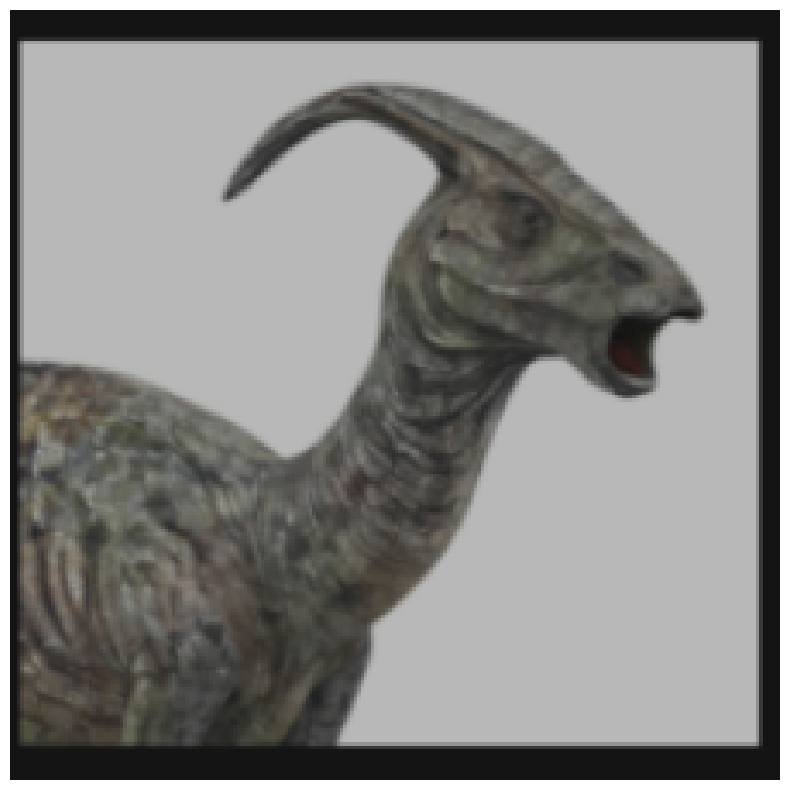

In [11]:
img, label = random.choice(train_ds)
img = img.unsqueeze(0)
visualize_image(img)

In [22]:
batch = next(iter(val_loader))

with torch.no_grad():
    x, y = batch
    features = feature_extractor(x)  # Shape: [batch_size, 512]

In [23]:
features.shape

torch.Size([64, 1280])

In [ ]:
from RexNet import RexNet

config = OmegaConf.load('config/config_rexnet.yaml')

model = RexNet(config=config.model, num_classes=config.num_classes)

# Carica direttamente dalla classe
model = RexNet.load_from_checkpoint(
    r'C:\Users\nicco\OneDrive\Documenti\JurassicClass\models\cross_validation\last_block_finetune\RexNet\fold_1\best-epoch=11-val_loss=0.5470-val_acc=0.8599.ckpt',
    config=config.model , # Devi passare gli argomenti non salvati    
    strict=False  # Ignora i pesi mancanti/extra
)
model.eval()

In [29]:
batch = next(iter(val_loader))

with torch.no_grad():
    x, y = batch
    features = feature_extractor(x)  # Shape: [batch_size, 512]

In [31]:
features.shape

torch.Size([64, 512])

In [69]:
prediction = model(img).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score}%")

German shepherd: 46.345722675323486%


#### Prova Training

In [5]:
import numpy as np
from argparse import ArgumentParser
from omegaconf import OmegaConf

from torchvision.models import ResNet18_Weights, EfficientNet_V2_S_Weights
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold, StratifiedKFold
from torch.utils.data import Subset
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning import Trainer, Callback
from lightning.pytorch.loggers import TensorBoardLogger

from utils import visualize_image, letterbox_to_square
from EfficentRex import EfficentRex
from RexNet import RexNet

In [6]:
train_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Lambda(lambda im: letterbox_to_square(im, size=config.size, fill=0)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),                 # (or 244 if you really want)
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    base_tfms,                                  # ToTensor + Normalize
])

val_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Lambda(lambda im: letterbox_to_square(im, size=config.size, fill=0)),
    transforms.CenterCrop(224),
    base_tfms,
])

root = "./dataset/dataset"

train_ds = datasets.ImageFolder(root=f"{root}/train", transform=train_tfms)
val_ds = datasets.ImageFolder(root=f"{root}/test", transform=val_tfms)  # Same data, different transforms


In [7]:
model_class = EfficentRex

config = OmegaConf.load('config/config_efficentrex.yaml')
print(config)

{'model': {'name': 'EfficentRex', 'layers_to_finetune': {'classifier': {'lr': 0.005, 'decay': 0.001}, 'features.6': {'lr': 0.0005, 'decay': 0.01}, 'features.7': {'lr': 0.0005, 'decay': 0.01}}}, 'experiment_name': 'last_block_finetune', 'training': {'max_epochs': 40, 'batch_size': 64}, 'num_classes': 8, 'size': 224}


In [10]:
model_class = RexNet

config = OmegaConf.load('config/config_rexnet.yaml')
print(config)

{'model': {'name': 'RexNet', 'layers_to_finetune': {'fc': {'lr': 0.005, 'decay': 0.001}, 'layer4': {'lr': 0.0005, 'decay': 0.01}}}, 'experiment_name': 'last_block_finetune', 'training': {'max_epochs': 40, 'batch_size': 64}, 'num_classes': 8, 'size': 224}


In [11]:
model = model_class(config=config.model, num_classes=config.num_classes)

print(f"Train subset size: {len(train_ds)}, Validation subset size: {len(val_ds)}")

train_loader = DataLoader(train_ds, batch_size=config.training.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=config.training.batch_size, shuffle=False, num_workers=0)


Train subset size: 1817, Validation subset size: 316


In [ ]:

early_stopping_callback = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=8)

checkpoint_callback = ModelCheckpoint(
    dirpath=f"./models/prova/{config.model.name}",
    filename="best-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}",  # Include both loss and accuracy
    save_top_k=1,
    monitor="val_loss",
    mode="min"
)

tb_logger = TensorBoardLogger(
    save_dir=f"./models/prova/{config.model.name}",  # parent dir
    name=f"tb_logs",                                            # subfolder name
    version=f"fold",                                     # unique run per fold
    default_hp_metric=False                                      # optional: disable hp metric
)

trainer = Trainer(
    default_root_dir=f"./models/prova/{model.model_name}",
    logger=tb_logger,
    limit_train_batches = 0.1,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=config.training.max_epochs,
    enable_checkpointing=True,
    log_every_n_steps=10
)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nicco\miniconda3\envs\daily_notes\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:658: Checkpoint directory C:\Users\nicco\OneDrive\Documenti\JurassicClass\models\prova\RexNet exists and is not empty.

  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | base_tfms  | ImageClassification | 0      | train
1 | model      | ResNet              | 21.3 M | train
2 | latent_rap | Sequential          | 21.3 M | train
-----------------------------------------------------------
13.1 M    Trainable params
8.2 M     Non-trainable params
21.3 M    Total params
85.155    Total estimated model params size (MB)
118       Modules in train mode
0         Modules in eval mode


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, v_num=fold, train_loss_step=6.060, train_acc_step=0.156, val_loss=2.390, val_acc=0.120, train_loss_epoch=4.120, train_acc_epoch=0.141]        